# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pprint
import time
import collections

from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
# from sklearn.preprocessing import OneHotEncoder

# from sklearn.preprocessing import Imputer


# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print(azdias.shape)
pd.options.display.max_rows = azdias.shape[1]
pd.options.display.max_columns = azdias.shape[1]

display(feat_info)

(891221, 85)


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


In [4]:
# display(azdias.sample(10))
display(azdias.head(10))

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,4,0,10.0,0,-1,15.0,4.0,2.0,2.0,1.0,1.0,0,0,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,-1,NaN,NaN,-1,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,1,1996,10.0,0,3,21.0,6.0,5.0,3.0,2.0,1.0,1,14,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3,1.0,0.0,2,5,0.0,2.0,0.0,6.0,NaN,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,1,1979,10.0,1,3,3.0,1.0,1.0,1.0,3.0,2.0,1,15,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2,0.0,0.0,1,5,17.0,1.0,0.0,4.0,NaN,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,6,1957,1.0,0,2,0.0,0.0,0.0,0.0,9.0,4.0,1,8,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1,0.0,0.0,1,3,13.0,0.0,0.0,1.0,NaN,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,1.0,4.0,4.0,2.0,6.0,4.0,0.0,4.0,1.0,0.0,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,5,1963,5.0,0,3,32.0,10.0,10.0,5.0,3.0,2.0,1,8,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2,0.0,0.0,2,4,20.0,4.0,0.0,5.0,1.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,3,1,2,2.0,3,1,5,2,2,5,2,1943,1.0,0,3,8.0,2.0,1.0,1.0,4.0,2.0,1,3,3.0,2,4,7,4,2,2,2,5,7,4,4,4,7,6,0,0.0,0.0,2,4,10.0,1.0,0.0,5.0,3.0,6.0,9.0,5.0,0.0,1.0,5.0,1992.0,W,7.0,8,8C,54,2.0,2.0,0.0,0.0,0.0,4.0,6.0,2.0,7.0,4.0,4.0,4.0,1.0,5.0,1300.0,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,-1,2,2,5.0,1,5,1,5,4,3,4,0,12.0,0,2,2.0,1.0,1.0,1.0,2.0,1.0,1,10,4.0,2,5,5,7,2,6,5,5,7,7,4,7,7,7,1,0.0,0.0,1,4,0.0,1.0,0.0,6.0,NaN,3.0,9.0,4.0,0.0,1.0,5.0,1992.0,W,5.0,4,4A,22,3.0,2.0,0.0,0.0,1.0,3.0,6.0,4.0,3.0,5.0,3.0,5.0,2.0,5.0,867.0,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,-1,1,1,3.0,3,3,4,1,3,2,5,1964,9.0,0,1,5.0,2.0,1.0,1.0,1.0,1.0,1,8,5.0,7,7,7,5,6,2,2,7,5,1,1,2,5,5,0,0.0,0.0,1,1,14.0,1.0,0.0,4.0,NaN,5.0,9.0,6.0,0.0,8.0,3.0,1992.0,W,1.0,2,2D,14,2.0,2.0,0.0,0.0,0.0,4.0,2.0,5.0,3.0,4.0,1.0,4.0,1.0,1.0,758.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,-1,3,1,3.0,4,4,2,4,2,2,6,1974,3.0,1,3,10.0,3.0,1.0,1.0,10.0,5.0,1,11,4.0,4,5,4,1,5,6,4,5,2,5,5,3,1,4,3,0.0,0.0,2,6,16.0,1.0,0.0,3.0,NaN,5.0,8.0,2.0,1.0,3.0,4.0,1992.0,W,1.0,1,1A,13,1.0,1.0,0.0,0.0,0.0,5.0,3.0,4.0,4.0,4.0,1.0,3.0,2.0,3.0,511.0,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,-1,3,2,4.0,2,4,2,3,5,4,1,1975,12.0,1,2,4.0,1.0,1.0,1.0,3.0,2.0,1,15,4.0,2,1,1,3,2,6,6,3,4,7,6,7,1,3,3,0.0,0.0,2,4,17.0,1.0,0.0,4.0,6.0,4.0,3.0,9.0,0.0,3.0,4.0,1992.0,W,7.0,1,1E,15,1.0,3.0,1.0,0.0,0.0,2.0,6.0,5.0,4.0,3.0,1.0,3.0,3.0,1.0,530.0,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0


In [5]:
print(azdias.describe())

            AGER_TYP  ALTERSKATEGORIE_GROB      ANREDE_KZ  CJT_GESAMTTYP  \
count  891221.000000         891221.000000  891221.000000  886367.000000   
mean       -0.358435              2.777398       1.522098       3.632838   
std         1.198724              1.068775       0.499512       1.595021   
min        -1.000000              1.000000       1.000000       1.000000   
25%        -1.000000              2.000000       1.000000       2.000000   
50%        -1.000000              3.000000       2.000000       4.000000   
75%        -1.000000              4.000000       2.000000       5.000000   
max         3.000000              9.000000       2.000000       6.000000   

       FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
count      891221.000000  891221.000000     891221.000000   891221.000000   
mean            3.074528       2.821039          3.401106        3.033328   
std             1.321055       1.464749          1.322134        1.529603   
min    

In [6]:
data_dict = None
with open('Data_Dictionary.md') as f:
    data_dict = f.read(-1)    
print(data_dict)

# Data Dictionary for Identify Customer Segments Data

## Introduction

The data for this project consist of two files:

- Udacity_AZDIAS_Subset.csv: demographics data for the general population of
      Germany; 891211 persons (rows) x 85 features (columns)
- Udacity_CUSTOMERS_Subset.csv: demographics data for customers of a mail-order
      company; 191652 persons (rows) x 85 features (columns)

The columns in the general demographics file and customers data file are the
same. This file documents the features that appear in the data files, sorted in
order of appearance. Sections of this file is based on the level of measurement
of each feature. The file "AZDIAS_Feature_Summary.csv" contains a summary of
feature attributes, including information level, data type, and codes for
missing or unknown values.

### Table of Contents

 1. Person-level features
 2. Household-level features
 3. Building-level features
 4. RR4 micro-cell features
 5. RR3 micro-cell features
 6. Postcode-level fe

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [7]:
# Identify missing or unknown data values and convert them to NaNs.
# Rubric - Have data values representing missing values been encoded consistently?

def convert_string_to_list(string):
    ret_list = []
    if string != '[]':
        string = string.replace('[','').replace(']','').split(',')
        ret_list = list(string)
        ret_list = [int(x) for x in ret_list if x.isdigit()]
    return ret_list

def fill_na(data):
    na_dict = {}
    for col in data.columns:
        before = data[col].isna().sum()
        to_be_replaced_values = convert_string_to_list(feat_info[feat_info['attribute'] == col]['missing_or_unknown'].values[0])
        nans = [np.nan] * len(to_be_replaced_values)
        data[col] = data[col].replace(to_be_replaced_values, nans)
        after = data[col].isna().sum()
        if after - before > 0:
            na_dict[col] = (before, after)
    return data, na_dict

In [8]:
azdias, na_dict = fill_na(azdias)
print(na_dict)
print(len(na_dict))

{'AGER_TYP': (0, 8340), 'ALTERSKATEGORIE_GROB': (0, 2881), 'GEBURTSJAHR': (0, 392318), 'LP_LEBENSPHASE_FEIN': (4854, 97632), 'LP_LEBENSPHASE_GROB': (4854, 94572), 'LP_FAMILIE_FEIN': (4854, 77792), 'LP_FAMILIE_GROB': (4854, 77792), 'NATIONALITAET_KZ': (0, 108315), 'PRAEGENDE_JUGENDJAHRE': (0, 108164), 'TITEL_KZ': (73499, 889061), 'ALTER_HH': (73499, 310267), 'W_KEIT_KIND_HH': (107602, 147988), 'ANZ_HAUSHALTE_AKTIV': (93148, 99611), 'KBA05_BAUMAX': (133324, 476524), 'KKK': (121196, 158064), 'REGIOTYP': (121196, 158064), 'ARBEIT': (97216, 97375), 'ORTSGR_KLS9': (97216, 97274), 'RELAT_AB': (97216, 97375)}
19


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [9]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
# Rubric - Has the quality of the data been assessed by looking at missing values by columns?
missing_data = azdias.isna().sum() # Column wise
print(missing_data)

AGER_TYP                   8340
ALTERSKATEGORIE_GROB       2881
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR              392318
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP                    0
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
SEMIO_ERL                     0
SEMIO_KU

In [10]:
pp = pprint.PrettyPrinter(indent=1)
pp.pprint(collections.Counter(missing_data))

Counter({0: 27,
         116515: 7,
         4854: 6,
         133324: 6,
         73499: 4,
         93148: 4,
         98979: 3,
         93740: 3,
         77792: 2,
         158064: 2,
         97375: 2,
         8340: 1,
         2881: 1,
         392318: 1,
         97632: 1,
         94572: 1,
         108315: 1,
         108164: 1,
         889061: 1,
         310267: 1,
         18348: 1,
         584612: 1,
         147988: 1,
         99611: 1,
         97008: 1,
         73969: 1,
         476524: 1,
         93155: 1,
         105800: 1,
         97274: 1})


Max(Missing Values): 889061 
Min(Missing Values): 0 
Mean(Missing Values): 86608.4588235294 
Median(Missing Values): 77792.0


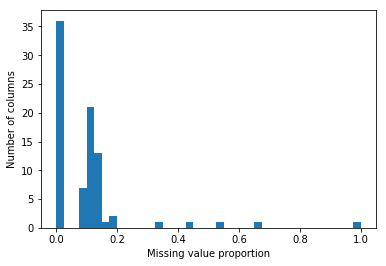

In [11]:
# Investigate patterns in the amount of missing data in each column.
print("Max(Missing Values): {} \nMin(Missing Values): {} \nMean(Missing Values): {} \nMedian(Missing Values): {}".format(missing_data.max(), missing_data.min(), missing_data.mean(), missing_data.median()))
missing_value_proportion = np.asarray(missing_data.tolist()) / azdias.shape[0] # To view in percentage
plt.hist(missing_value_proportion, 40)
plt.xlabel("Missing value proportion")
plt.ylabel("Number of columns")
plt.show()

In [12]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
e = 0.05
threshold = missing_data.median()/azdias.shape[0] + e # Number of columns having missing values more than the threshold i.e. median of number of missing values + a small value to egulate the number of columns to be dropped
print(threshold)
cols_to_delete = [i for i in range(len(missing_value_proportion)) if missing_value_proportion[i] > threshold]
cols_to_delete = azdias.columns[[cols_to_delete]]
azdias_dropped = azdias.drop(cols_to_delete, axis=1)
print(azdias_dropped.shape)
print(cols_to_delete)

0.137286991666
(891221, 71)
Index(['GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'W_KEIT_KIND_HH',
       'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4',
       'KBA05_BAUMAX', 'KBA05_GBZ', 'KKK', 'MOBI_REGIO', 'REGIOTYP'],
      dtype='object')


#### Discussion 1.1.2: Assess Missing Data in Each Column


After replacing the unknown values with NAs in the dataset, it turned out that there are many columns with large amount of missing data. 19 features had a change in the number of missing values after performing this step. The dataset has 891221 rows, out of which TITEL_KZ has 889061 values missing making it the feature with maximum missing values. Out of 85 columns in the original dataset although 27 features had no missing values, there are patterns in the number of missing values in the other columns which are listed as following:
 - 7 of them had 116,515 missing values. All of these are PLZ8 macro-cell features which talks about the neighbourhood of the person. It might be possible that these folks belongs to a region for which this sort of data wasn't collected or wasn't available. 
 - 6 of the features had 133,324 values missing. 5 of these are RR3 micro-cell features which depicts the number of members in the family in that cell. MOBI_REGIO, which shows the movement pattern, is another feature with same number of values missing. This is likely as people tend to avoid publicizing such information for privacy reasons.
 - 6 of the features had 4,854 values missing. LP_STATUS_FEIN and LP_STATUS_GROB are two of them which shows the social status of a person on fine and rough scale. ONLINE_AFFINITAET shows the online affinity, GFK_URLAUBERTYP shows the vacation habits, CJT_GESAMTTYP shows the preferred information and buying channels, and RETOURTYP_BK_S shows the shopping return type of a person. These pieces of information are sometimes difficult to collect pertaining to the complexity & ambiguity of the rules.
 - 4 of the features had 73,499 values missing. SOHO_KZ showing if a person has a small/home office or not, ANZ_PERSONEN showing the number of adults in the household, ANZ_TITEL showing the number of professional academic title holders in household, and WOHNDAUER_2008 showing the length of residence in years are the features belonging to this bucket. 
- 4 of the features had 93,148 values missing.
- 3 of the features had 98,979 values missing.
- 3 of the features had 98,979 values missing.
- 3 of the features had 93,740 values missing.
- 2 of the features had 77,792 values missing.
- 2 of the features had 158,064 values missing. KKK and REGIOTYP are the two features in this bucket, showing the purchasing power of the region and the neighborhood typology. 
- 2 of the features had 97,375 values missing.

I've not analysed features in each bucket here as the reasons for having these data points unavailable are either people choosing not to disclose particular information, complexity of the logic to classify a person for a feature, and complexity of the data collection in certain cases, like PLZ8 macro-cell features. 
Apart from these, all the other counts of missing values are unique.

In order to remove colmuns having a high number of missing values, I chose the median of the missing values across columns and regulated it with the variable e (denoting `epsilon`). By this logic, all the columns having the proportion of missing values greater than 0.137286991666 (13.7%) were dropped. 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'W_KEIT_KIND_HH','KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_BAUMAX', 'KBA05_GBZ', 'KKK', 'MOBI_REGIO', 'REGIOTYP' are the columns which got dropped. The dataset features were reduced to 71 from 85.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [13]:
# How much data is missing in each row of the dataset?
# Rubric - Has the quality of the data been assessed by looking at missing values by rows?
missing_value_rows = azdias_dropped.isna().sum(axis=1)
print(missing_value_rows.describe())
print("Max(Missing Values): {} \nMin(Missing Values): {} \nMean(Missing Values): {} \nMedian(Missing Values): {}".format(missing_value_rows.max(), missing_value_rows.min(), missing_value_rows.mean(), missing_value_rows.median()))

count    891221.000000
mean          3.865345
std           9.781847
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          37.000000
dtype: float64
Max(Missing Values): 37 
Min(Missing Values): 0 
Mean(Missing Values): 3.8653454081535332 
Median(Missing Values): 0.0


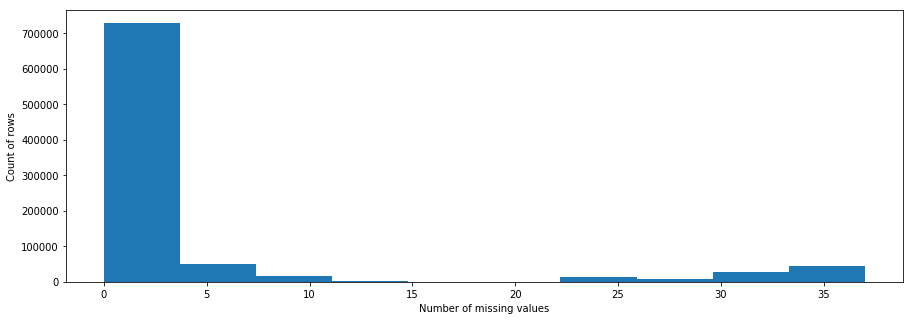

In [14]:
plt.figure(figsize=(15, 5))
plt.hist(missing_value_rows, 10)
plt.xlabel("Number of missing values")
plt.ylabel("Count of rows")
plt.show()

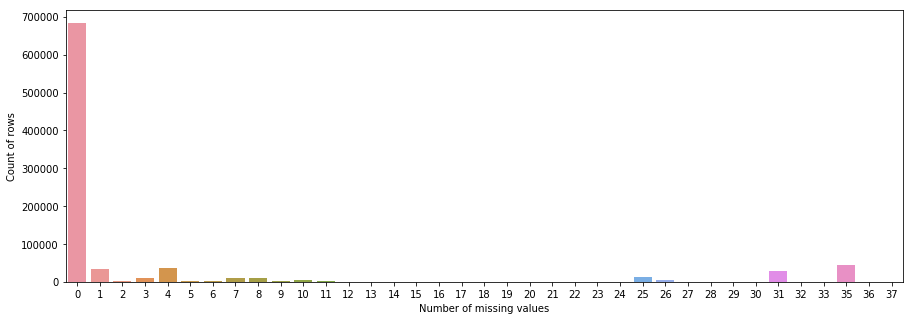

In [15]:
plt.figure(figsize=(15, 5))
ax = sns.countplot(missing_value_rows)
ax.set_xlabel('Number of missing values')
ax.set_ylabel('Count of rows')
plt.show()

In [16]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
azdias_dropped['null_values'] = missing_value_rows
azdias_dropped_low = azdias_dropped[azdias_dropped['null_values'] <= 24]
azdias_dropped_high = azdias_dropped[azdias_dropped['null_values'] > 24]
azdias_dropped_low = azdias_dropped_low.drop('null_values', axis=1)
azdias_dropped_high = azdias_dropped_high.drop('null_values', axis=1)
print(azdias_dropped_low.shape, azdias_dropped_high.shape, sep='\n')


(798554, 71)
(92667, 71)


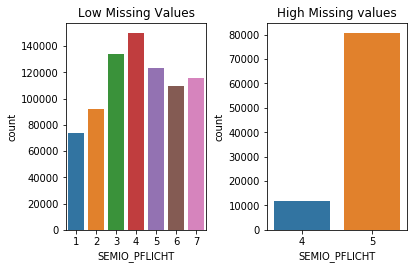

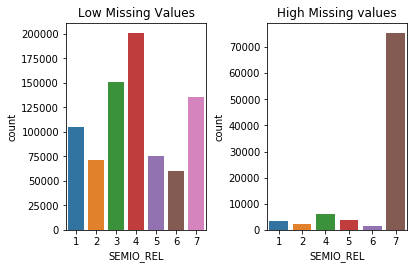

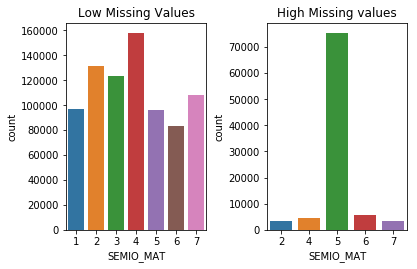

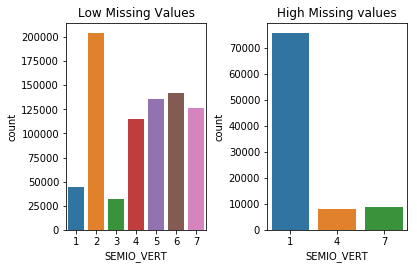

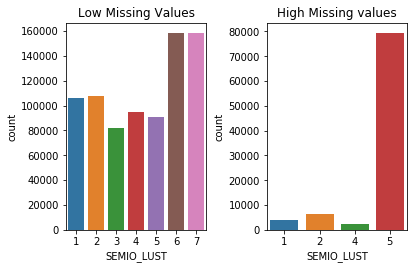

In [17]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

def plot_column_dist_across_groups(column):
    fig, (ax1, ax2) = plt.subplots(1,2) # Two columns for both groups 
    fig.tight_layout(pad=3.0)
    ax1.set_title('Low Missing Values')
    ax2.set_title('High Missing values')
    
    sns.countplot(azdias_dropped_low[column], ax=ax1)
    sns.countplot(azdias_dropped_high[column], ax=ax2)
    plt.show()

cols = azdias_dropped.isna().sum().sort_values(ascending=True)[:5]
for col in cols.index.tolist():
    plot_column_dist_across_groups(col)

#### Discussion 1.1.3: Assess Missing Data in Each Row

The seaborn countplot showed that the number of rows having missing values in the range of 12 to 24 is zero or extremely low . So I decided to seperate the rows which have more than 24 missing values from the dataset. 

After this I chose 5 columns which have 0 missing data (27 features have 0 missing values, took a subset of 5 by sorting the list of missing values in increasing order) and plotted its distribution for both the datasets. It turns out all of these variables are personality typology type. They are as following: 

SEMIO_PFLICHT
SEMIO_REL
SEMIO_MAT
SEMIO_VERT
SEMIO_LUST

All of these have very different distribution in both the datasets. In fact the unique data points in both the datasets for the same column are different as well. This proves that dropping the data with high NaN values might not be the best approach as the data itself is getting disfigured by this step. Thus, the data with lots of missing values are qualitatively different from data with few or no missing values.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [18]:
# How many features are there of each data type?
print(feat_info.columns)
print(feat_info['type'].value_counts())

Index(['attribute', 'information_level', 'type', 'missing_or_unknown'], dtype='object')
ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: type, dtype: int64


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [19]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
# Rubric - Have categorical features been properly processed?
categorical_columns_total = [col for col in feat_info[feat_info['type'] == 'categorical']['attribute']]
categorical_columns_azdias_dropped = set(categorical_columns_total) & set(azdias_dropped.columns)
cols_to_be_encoded = []
for col in categorical_columns_azdias_dropped:
    if azdias_dropped[col].describe().dtype == object: # Non-numeric values
        print(azdias_dropped[col].value_counts())
    else:
        print(azdias_dropped[col].value_counts())
        cols_to_be_encoded.append(col)

4.0    210963
3.0    156449
6.0    153915
2.0    148795
5.0    117376
1.0     98869
Name: CJT_GESAMTTYP, dtype: int64
W    629528
O    168545
Name: OST_WEST_KZ, dtype: int64
6B    56672
8A    52438
4C    47819
2D    35074
3C    34769
7A    34399
3D    34307
8B    33434
4A    33155
8C    30993
9D    28593
9B    27676
9C    24987
7B    24503
9A    20542
2C    19422
8D    17576
6E    16107
2B    15486
5D    14943
6C    14820
2A    13249
5A    12214
1D    11909
1A    10850
3A    10543
5B    10354
5C     9935
7C     9065
4B     9047
4D     8570
3B     7160
6A     6810
9E     6379
6D     6073
6F     5392
7D     5333
4E     5321
1E     5065
7E     4633
1C     4317
5F     4283
1B     4071
5E     3581
XX      373
Name: CAMEO_DEU_2015, dtype: int64
0    715996
1    175225
Name: GREEN_AVANTGARDE, dtype: int64
6    290367
1    199572
4    130625
2    110867
5    106436
3     53354
Name: FINANZTYP, dtype: int64
12.0    138545
5.0     120126
10.0    109127
8.0      88042
11.0     79740
4.0      6377

In [20]:
cols_to_be_encoded.remove('ANREDE_KZ')
cols_to_be_encoded.remove('GREEN_AVANTGARDE')
cols_to_be_encoded.remove('SOHO_KZ')

azdias_dropped_low['ANREDE_KZ'] = azdias_dropped_low['ANREDE_KZ'].replace({1:0, 2:1})
print(azdias_dropped_low['ANREDE_KZ'].value_counts())

1    416401
0    382153
Name: ANREDE_KZ, dtype: int64


In [21]:
# OST_WEST_KZ has 2 possible values and is being encoded manually at the encoding step (next cells)
cols_to_be_encoded.append('CAMEO_DEU_2015')
cols_to_be_encoded.append('CAMEO_DEUG_2015')
print(cols_to_be_encoded)

['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'SHOPPER_TYP', 'VERS_TYP', 'GEBAEUDETYP', 'LP_STATUS_GROB', 'AGER_TYP', 'ZABEOTYP', 'LP_STATUS_FEIN', 'LP_FAMILIE_GROB', 'NATIONALITAET_KZ', 'LP_FAMILIE_FEIN', 'CAMEO_DEU_2015', 'CAMEO_DEUG_2015']


In [22]:
# Re-encode categorical variable(s) to be kept in the analysis.

# All the NAs have to be filled first before one hot encoding
most_frequent_value_low = None
    
for col in cols_to_be_encoded: # For categorical variables as statistical methods would be misleading
    if azdias_dropped_low[col].isna().sum() == azdias_dropped_low.shape[0]:
        print(azdias_dropped_low[col].isna().sum())
    else:
        most_frequent_value_low = azdias_dropped_low[col].value_counts().idxmax()
    azdias_dropped_low[col] = azdias_dropped_low[col].fillna(most_frequent_value_low)

In [23]:
for col in cols_to_be_encoded:
    temp_cols = set(azdias_dropped_low.columns.tolist())
    azdias_dropped_low = pd.concat([azdias_dropped_low, pd.get_dummies(azdias_dropped_low[col], prefix=col)], sort=True, axis=1)
    azdias_dropped_low = azdias_dropped_low.drop(col, axis=1)
    print("Dropped from low: " + col)
    print(str(azdias_dropped_low.shape))
    print(set(azdias_dropped_low.columns.tolist()) - temp_cols)

Dropped from low: CJT_GESAMTTYP
(798554, 76)
{'CJT_GESAMTTYP_2.0', 'CJT_GESAMTTYP_5.0', 'CJT_GESAMTTYP_6.0', 'CJT_GESAMTTYP_4.0', 'CJT_GESAMTTYP_1.0', 'CJT_GESAMTTYP_3.0'}
Dropped from low: FINANZTYP
(798554, 81)
{'FINANZTYP_6', 'FINANZTYP_3', 'FINANZTYP_2', 'FINANZTYP_4', 'FINANZTYP_1', 'FINANZTYP_5'}
Dropped from low: GFK_URLAUBERTYP
(798554, 92)
{'GFK_URLAUBERTYP_12.0', 'GFK_URLAUBERTYP_8.0', 'GFK_URLAUBERTYP_1.0', 'GFK_URLAUBERTYP_7.0', 'GFK_URLAUBERTYP_5.0', 'GFK_URLAUBERTYP_6.0', 'GFK_URLAUBERTYP_2.0', 'GFK_URLAUBERTYP_10.0', 'GFK_URLAUBERTYP_3.0', 'GFK_URLAUBERTYP_4.0', 'GFK_URLAUBERTYP_11.0', 'GFK_URLAUBERTYP_9.0'}
Dropped from low: SHOPPER_TYP
(798554, 96)
{'SHOPPER_TYP_2', 'SHOPPER_TYP_-1', 'SHOPPER_TYP_0', 'SHOPPER_TYP_1', 'SHOPPER_TYP_3'}
Dropped from low: VERS_TYP
(798554, 98)
{'VERS_TYP_-1', 'VERS_TYP_1', 'VERS_TYP_2'}
Dropped from low: GEBAEUDETYP
(798554, 104)
{'GEBAEUDETYP_5.0', 'GEBAEUDETYP_1.0', 'GEBAEUDETYP_8.0', 'GEBAEUDETYP_2.0', 'GEBAEUDETYP_4.0', 'GEBAEUDETYP_3.

In [24]:
print(azdias_dropped_low.shape)

(798554, 194)


In [25]:
azdias_dropped_low['OST_WEST_KZ'] = azdias_dropped_low['OST_WEST_KZ'].replace({'W':1, 'O':0})
print(azdias_dropped_low['OST_WEST_KZ'].value_counts())

1.0    629528
0.0    168545
Name: OST_WEST_KZ, dtype: int64


#### Discussion 1.2.1: Re-Encode Categorical Features
The ver first step I did in the re-encoding exercise is to find out the categorical features which have non-numeric data values. These features are 
 - CAMEO_DEU_2015, 
 - CAMEO_DEUG_2015, and
 - OST_WEST_KZ.
 
OST_WEST_KZ is the feature which has been mentioned in the instructions as the binary variable which takes non-numeric values. This has been  encoded as 1 and 0 for W and O respectively, inplace. On the other hand, the other two variables have more than two values and is encoded using pandas method `get_dummies`. Before one hot encoding, all the NAs were filled by the most frequent value in the column, very analogous to an option of sklearn imputer. As the features are categorical, methods like mean, median etc doesn't make sense here. The original columns were dropped and the one hot encoded features were added back to the dataframe increasing the dimensionality.

There are three binary variables in the dataset which are as follows: 
 - ANREDE_KZ which has values 1 and 2
 - GREEN_AVANTGARDE which has values 0 and 1 
 - SOHO_KZ which has values 0 and 1
 
Although these can be left as is, as they are boolean variables, I chose to manually encode ANREDE_KZ from 1 and 2 to 0 and 1 respectively for the sake of uniform treatment.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

### 1.18. PRAEGENDE_JUGENDJAHRE
Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
- -1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)

In [26]:
print(azdias_dropped_low['PRAEGENDE_JUGENDJAHRE'].value_counts().sort_index())

1.0      20722
2.0       7479
3.0      53904
4.0      20451
5.0      84736
6.0      25652
7.0       4010
8.0     141691
9.0      33570
10.0     85808
11.0     35752
12.0     24446
13.0      5764
14.0    183258
15.0     42547
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64


In [27]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
# Rubric - Have mixed-type features been properly processed?
# The above cell shows -1 and 0 have been removed from this column, if existed

movement_map ={1:0,2:1,3:0,4:1,5:0,6:1,7:1,8:0,9:1,10:0,11:1,12:0,13:1,14:0,15:1} # Mainstream - 0, Avantgarde - 1
decade_map = {1:40, 2:40,3:50,4:50,5:60,6:60,7:60,8:70,9:70,10:80,11:80,12:80,13:80,14:90,15:90}

azdias_dropped_low['MOVEMENT'] = azdias_dropped_low['PRAEGENDE_JUGENDJAHRE'].map(movement_map)
azdias_dropped_low['DECADE'] = azdias_dropped_low['PRAEGENDE_JUGENDJAHRE'].map(decade_map)

# Investigate "CAMEO_INTL_2015" and engineer two new variables.

### 4.3. CAMEO_INTL_2015
German CAMEO: Wealth / Life Stage Typology, mapped to international code
- -1: unknown
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement
- XX: unknown

In [28]:
print(azdias_dropped_low['CAMEO_INTL_2015'].value_counts().sort_index())

12     13249
13     26336
14     62884
15     16974
22     33155
23     26750
24     91158
25     39628
31     19024
32     10354
33      9935
34     18524
35     10356
41     92336
43     56672
44     14820
45     26132
51    133694
52     20542
54     45391
55     23955
XX       373
Name: CAMEO_INTL_2015, dtype: int64


In [29]:
def map_func(val, arg):
    ret = np.nan
    try:
        val = int(val)
        if len(str(val)) == 2:
            ret = int(str(val)[arg])
    except:
        pass
    return ret

azdias_dropped_low['WEALTH'] = azdias_dropped_low['CAMEO_INTL_2015'].apply(lambda x: map_func(x, 0))
azdias_dropped_low['LIFE_STAGE'] = azdias_dropped_low['CAMEO_INTL_2015'].apply(lambda x: map_func(x, 1))

In [30]:
print(azdias_dropped_low['MOVEMENT'].value_counts())
print(azdias_dropped_low['DECADE'].value_counts())
print(azdias_dropped_low['WEALTH'].value_counts())
print(azdias_dropped_low['LIFE_STAGE'].value_counts())

0.0    594565
1.0    175225
Name: MOVEMENT, dtype: int64
90.0    225805
70.0    175261
80.0    151770
60.0    114398
50.0     74355
40.0     28201
Name: DECADE, dtype: int64
5.0    223582
2.0    190691
4.0    189960
1.0    119443
3.0     68193
Name: WEALTH, dtype: int64
1.0    245054
4.0    232777
3.0    119693
5.0    117045
2.0     77300
Name: LIFE_STAGE, dtype: int64


In [31]:
for col in ['MOVEMENT', 'DECADE', 'WEALTH', 'LIFE_STAGE']:
    if azdias_dropped_low[col].isna().sum() == azdias_dropped_low.shape[0]:
        print(azdias_dropped_low[col].isna().sum())
    else:
        most_frequent_value_low = azdias_dropped_low[col].value_counts().idxmax()
    azdias_dropped_low[col] = azdias_dropped_low[col].fillna(most_frequent_value_low)

In [32]:
mixed_columns_total = [col for col in feat_info[feat_info['type'] == 'mixed']['attribute']]
mixed_columns_azdias_dropped_low = set(mixed_columns_total) & set(azdias_dropped_low.columns)
print(mixed_columns_azdias_dropped_low)

{'CAMEO_INTL_2015', 'PRAEGENDE_JUGENDJAHRE', 'PLZ8_BAUMAX', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'WOHNLAGE'}


## Pasting the feature description of these four features

### 8.6. PLZ8_BAUMAX
Most common building type within the PLZ8 region
- -1: unknown
-  0: unknown
-  1: mainly 1-2 family homes
-  2: mainly 3-5 family homes
-  3: mainly 6-10 family homes
-  4: mainly 10+ family homes
-  5: mainly business buildings

### 3.7. WOHNLAGE
Neighborhood quality (or rural flag)
- -1: unknown
-  0: no score calculated
-  1: very good neighborhood
-  2: good neighborhood
-  3: average neighborhood
-  4: poor neighborhood
-  5: very poor neighborhood
-  7: rural neighborhood
-  8: new building in rural neighborhood

### 1.11. LP_LEBENSPHASE_FEIN
Life stage, fine scale
-  1: single low-income earners of younger age
-  2: single low-income earners of middle age
-  3: single average earners of younger age
-  4: single average earners of middle age
-  5: single low-income earners of advanced age
-  6: single low-income earners at retirement age
-  7: single average earners of advanced age
-  8: single average earners at retirement age
-  9: single independent persons
- 10: wealthy single homeowners
- 11: single homeowners of advanced age
- 12: single homeowners at retirement age
- 13: single top earners of higher age
- 14: low-income and average earner couples of younger age
- 15: low-income earner couples of higher age
- 16: average earner couples of higher age
- 17: independent couples
- 18: wealthy homeowner couples of younger age
- 19: homeowner couples of higher age
- 20: top earner couples of higher age
- 21: single parent low-income earners
- 22: single parent average earners
- 23: single parent high-income earners
- 24: low-income earner families
- 25: average earner families
- 26: independent families
- 27: homeowner families
- 28: top earner families
- 29: low-income earners of younger age from multiperson households
- 30: average earners of younger age from multiperson households
- 31: low-income earners of higher age from multiperson households
- 32: average earners of higher age from multiperson households
- 33: independent persons of younger age from multiperson households
- 34: homeowners of younger age from multiperson households
- 35: top earners of younger age from multiperson households
- 36: independent persons of higher age from multiperson households
- 37: homeowners of advanced age from multiperson households
- 38: homeowners at retirement age from multiperson households
- 39: top earners of middle age from multiperson households
- 40: top earners at retirement age from multiperson households

### 1.12. LP_LEBENSPHASE_GROB
Life stage, rough scale
-  1: single low-income and average earners of younger age
-  2: single low-income and average earners of higher age
-  3: single high-income earners
-  4: single low-income and average-earner couples
-  5: single high-income earner couples
-  6: single parents
-  7: single low-income and average earner families
-  8: high-income earner families
-  9: average earners of younger age from multiperson households
- 10: low-income and average earners of higher age from multiperson households
- 11: high-income earners of younger age from multiperson households
- 12: high-income earners of higher age from multiperson households


#### Discussion 1.2.2: Engineer Mixed-Type Features

 - PRAEGENDE_JUGENDJAHRE: This feature has been mapped to two new features MOVEMENT and DECADE. 'MOVEMENT' feature shows the movement of the person, 0 being mainstream and 1 being avantgarde. 'DECADE' feature shows the decade of person's youth. It's values ranges in (40, 50, 60, 70, 80, 90). The original feature would be dropped at a later stage.
 - CAMEO_INTL_2015: This feature has been mapped to two new features WEALTH and LIFE_STAGE. 'WEALTH' is denoted by the tens place in the values of CAMEO_INTL_2015 whereas 'LIFE_STAGE' is denoted by the ones place. This is equivalent to 0th and 1st index respectively if the value is converted to a string. This is what the method map_func does and returns the WEALTH or LIFE_STAGE depending on the argument passed. For unknown values, NAN has been filled for both the derived columns. The original feature would be dropped at a later stage.
 - PLZ8_BAUMAX - This feature contains information about most common building type within the PLZ8 region. The other PLZ8_ANTG* variables covers this information. This feature would be dropped at a later stage.
 - LP_LEBENSPHASE_GROB - This denotes the life stage of a person at a rough scale. CAMEO_INTL_2015 was used to create a derived feature for the same. This feature would be dropped at a later stage.
 - WOHNLAGE - This feature denotes the neighbourhood quality which would be quite pertinent to our analysis. For this reason, this feature is kept as is.
 - LP_LEBENSPHASE_FEIN - This denotes the life stage of a person at a fine scale. CAMEO_INTL_2015 was used to create a derived feature for the same. This feature would be dropped at a later stage.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [33]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)
# Rubric - Has the dataset been cleaned to include only relevant columns?
mixed_columns_azdias_dropped_low.remove('WOHNLAGE')
print(mixed_columns_azdias_dropped_low)

for col in mixed_columns_azdias_dropped_low:
    if col in azdias_dropped_low.columns:
        print(col)
        azdias_dropped_low = azdias_dropped_low.drop(col, axis=1)

{'CAMEO_INTL_2015', 'PRAEGENDE_JUGENDJAHRE', 'PLZ8_BAUMAX', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB'}
CAMEO_INTL_2015
PRAEGENDE_JUGENDJAHRE
PLZ8_BAUMAX
LP_LEBENSPHASE_FEIN
LP_LEBENSPHASE_GROB


In [34]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
ordinal_columns = [col for col in feat_info[feat_info['type'] == 'ordinal']['attribute']]
categorical_columns = [col for col in feat_info[feat_info['type'] == 'categorical']['attribute']]
mixed_columns = [col for col in feat_info[feat_info['type'] == 'mixed']['attribute']]
numeric_columns = [col for col in feat_info[feat_info['type'] == 'numeric']['attribute']]
interval_columns = [col for col in feat_info[feat_info['type'] == 'interval']['attribute']]
cols = azdias_dropped_low.columns

for col in numeric_columns + interval_columns + ordinal_columns :
    if col not in cols_to_delete and col not in cols: # If nothing is printed, all numeric, interval, and ordinal columns are present
        print(col)
mixed_columns.remove('WOHNLAGE')
for col in mixed_columns:
    if col not in cols_to_delete and col in cols: # Apart from WOHNLAGE no other mixed columns should be left as is
        print(col)
categorical_columns.remove('OST_WEST_KZ')
for col in categorical_columns:
    if col not in cols_to_delete and col in cols: # Apart from OST_WEST_KZ, which is encoded at place, no other categorical columns should be left as is
        print(col)
print(len(cols))

ANREDE_KZ
GREEN_AVANTGARDE
SOHO_KZ
193


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [210]:
# Rubric - Has a function performing cleaning operations been created?
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    df, na_dict = fill_na(df)
    print("(NAs before, NAs after)", na_dict)
    
    # remove selected columns and rows, ...
    # Performing the same exercise might result in different columns to delete because of the nulls present in the new data
    # Instead these column names are taken from the other cols_to_delete list
    cols_to_delete = ['GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'W_KEIT_KIND_HH',
       'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4',
       'KBA05_BAUMAX', 'KBA05_GBZ', 'KKK', 'MOBI_REGIO', 'REGIOTYP']
    df = df.drop(cols_to_delete, axis=1)
    
    missing_value_rows = df.isna().sum(axis=1)
    df['null_values'] = missing_value_rows
    df = df[df['null_values'] <= 24]
    df = df.drop('null_values', axis=1)
    
    # select, re-encode, and engineer column values.
    
    cols_to_be_encoded = ['ZABEOTYP', 'FINANZTYP', 'NATIONALITAET_KZ', 'LP_STATUS_GROB', 'LP_STATUS_FEIN', 'VERS_TYP', 'CJT_GESAMTTYP', 'AGER_TYP', 'LP_FAMILIE_FEIN', 'SHOPPER_TYP', 'GEBAEUDETYP', 'LP_FAMILIE_GROB', 'GFK_URLAUBERTYP', 'CAMEO_DEU_2015', 'CAMEO_DEUG_2015']
    
    df['ANREDE_KZ'] = df['ANREDE_KZ'].replace({1:0, 2:1})

    most_frequent_value_low = None
    
    for col in cols_to_be_encoded: # For categorical variables as statistical methods would be misleading
        if df[col].isna().sum() == df.shape[0]:
            print(df[col].isna().sum())
        else:
            most_frequent_value_low = df[col].value_counts().idxmax()
        df[col] = df[col].fillna(most_frequent_value_low)
        
    for col in cols_to_be_encoded:
        temp_cols = set(df.columns.tolist())
        df = pd.concat([df, pd.get_dummies(df[col], prefix=col)], sort=True, axis=1)
        df = df.drop(col, axis=1)
        print(str(df.shape))
        print(set(df.columns.tolist()) - temp_cols) 
        
    df['OST_WEST_KZ'] = df['OST_WEST_KZ'].replace({'W':1, 'O':0})
    
    movement_map ={1:0,2:1,3:0,4:1,5:0,6:1,7:1,8:0,9:1,10:0,11:1,12:0,13:1,14:0,15:1} # Mainstream - 0, Avantgarde - 1
    decade_map = {1:40, 2:40,3:50,4:50,5:60,6:60,7:60,8:70,9:70,10:80,11:80,12:80,13:80,14:90,15:90}

    df['MOVEMENT'] = df['PRAEGENDE_JUGENDJAHRE'].map(movement_map)
    df['DECADE'] = df['PRAEGENDE_JUGENDJAHRE'].map(decade_map)
    
    df['WEALTH'] = df['CAMEO_INTL_2015'].apply(lambda x: map_func(x, 0))
    df['LIFE_STAGE'] = df['CAMEO_INTL_2015'].apply(lambda x: map_func(x, 1))
    
    for col in ['MOVEMENT', 'DECADE', 'WEALTH', 'LIFE_STAGE']:
        if df[col].isna().sum() == df.shape[0]:
            print(df[col].isna().sum())
        else:
            most_frequent_value_low = df[col].value_counts().idxmax()
        df[col] = df[col].fillna(most_frequent_value_low)
        
    mixed_columns_total = [col for col in feat_info[feat_info['type'] == 'mixed']['attribute']]
    mixed_columns_df = set(mixed_columns_total) & set(df.columns)

    mixed_columns_df.remove('WOHNLAGE')

    for col in mixed_columns_df:
        if col in df.columns:
            print(col)
            df = df.drop(col, axis=1)

    # Return the cleaned dataframe.
    return df
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [36]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
nulls = azdias_dropped_low.isna().sum(axis=0)
null_index = nulls.index
null_values = nulls.tolist()
nulls = dict(zip(null_index, null_values))
nulls = {index: value for index, value in nulls.items() if value != 0}
pp.pprint(nulls)

{'ALTERSKATEGORIE_GROB': 2803,
 'ANZ_HAUSHALTE_AKTIV': 6944,
 'ANZ_HH_TITEL': 4341,
 'ARBEIT': 4708,
 'BALLRAUM': 1073,
 'EWDICHTE': 1073,
 'GEBAEUDETYP_RASTER': 488,
 'INNENSTADT': 1073,
 'KBA13_ANZAHL_PKW': 13133,
 'KONSUMNAEHE': 72,
 'MIN_GEBAEUDEJAHR': 481,
 'ONLINE_AFFINITAET': 4754,
 'ORTSGR_KLS9': 4607,
 'OST_WEST_KZ': 481,
 'PLZ8_ANTG1': 23848,
 'PLZ8_ANTG2': 23848,
 'PLZ8_ANTG3': 23848,
 'PLZ8_ANTG4': 23848,
 'PLZ8_GBZ': 23848,
 'PLZ8_HHZ': 23848,
 'RELAT_AB': 4708,
 'RETOURTYP_BK_S': 4754,
 'WOHNLAGE': 481}


In [37]:
imputer = Imputer(strategy='most_frequent')
azdias_dropped_low = pd.DataFrame(imputer.fit_transform(azdias_dropped_low), index=azdias_dropped_low.index, columns=azdias_dropped_low.columns)

In [38]:
nulls = azdias_dropped_low.isna().sum(axis=0)
null_index = nulls.index
null_values = nulls.tolist()
nulls = dict(zip(null_index, null_values))
nulls = {index: value for index, value in nulls.items() if value != 0}
pp.pprint(nulls)

{}


In [39]:
# Apply feature scaling to the general population demographics data.
# Rubric - Has feature scaling been applied to the data?
scaler = StandardScaler()
azdias_dropped_low = pd.DataFrame(scaler.fit_transform(azdias_dropped_low), index=azdias_dropped_low.index, columns=azdias_dropped_low.columns)

### Discussion 2.1: Apply Feature Scaling

After dropping the required columns and making sure that I am working with the set of features I intend to, I looked at the NAs in the dataset. There were 23 columns with NAs as their values. This was again replaced by the most frequent value in the column using sklearn Imputer class. All the NAs were removed from the dataset.

Post that, sklearn StandardScaler was used to scale the values. Quoting from the documentation it "Standardize features by removing the mean and scaling to unit variance". This is a necessary step as the further steps delve on distance based metrics and disparity in the scale would be catastrophic.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [40]:
# Apply PCA to the data.
pca = PCA()
pca_fit = pca.fit(azdias_dropped_low)

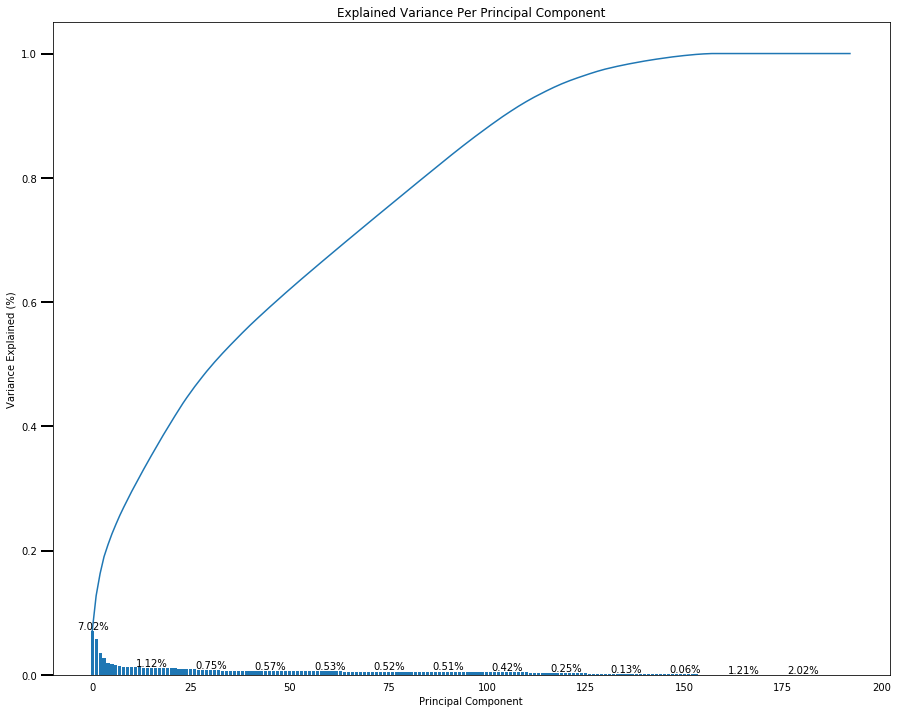

In [41]:
# Investigate the variance accounted for by each principal component.
# The following code is taken from the lesson - Unsupervised Learning/4.Dimensionality Reduction and PCA/Screencast: Interpret PCA Results
# Modified at places to work fairly for this dataset

def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(15, 12))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(0,num_components,15):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=10)
    
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

scree_plot(pca_fit)

In [42]:
# As readability of the variance is low in the graph, checking it here
vals = pca.explained_variance_ratio_
cumvals = np.cumsum(vals)
chks = list(np.arange(0.1, 1.2, 0.1))
k = 0
for i,v in enumerate(cumvals):
    if v > chks[k]:
        print(i, v)
        if k <= len(chks) - 1: 
            k += 1
        else:
            break

1 0.127324121653
4 0.209410680638
11 0.306973180138
20 0.406754337034
31 0.503287570566
47 0.603427933613
65 0.701129884142
84 0.800577503914
105 0.902775487257


In [43]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(85)
X_pca = pca.fit_transform(azdias_dropped_low)
X_pca.shape

(798554, 85)

### Discussion 2.2: Perform Dimensionality Reduction

sklearn PCA class has been used to find the principal components in this dataset. The scree plot shows the individual and cumulative variance of principal components thus derived. Further analysis shows that just the first two principal components account for more than 12% of the variation in the data. Similarly, the first 5 account for ~21% and first 12 account for 31% of the variation. The increase in encapsulating variation decreases as we move further in the principal components.

I chose to live with 85 principal components which account for 80% variation in the dataset. The dataset has been transformed accordingly.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [44]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def interpret_pca(pca, component, columns, num_columns=5):
    component_columns_df = pd.DataFrame({'feature': columns, 'weight': pca.components_[component]}).sort_values(by='weight')
    print('BOTTOM {} features against PC{} are: \n{}'.format(num_columns, component, component_columns_df.iloc[:num_columns,:].to_string(index=False)), end='\n\n')
    print('TOP {} features against PC{} are: \n{}'.format(num_columns, component, component_columns_df.iloc[-num_columns:,:].to_string(index=False)))

interpret_pca(pca, 0, azdias_dropped_low.columns)

BOTTOM 5 features against PC0 are: 
feature    weight
   FINANZ_MINIMALIST -0.219114
          PLZ8_ANTG1 -0.161749
ALTERSKATEGORIE_GROB -0.154882
    FINANZ_VORSORGER -0.154332
         KONSUMNAEHE -0.123214

TOP 5 features against PC0 are: 
feature    weight
        PLZ8_ANTG3  0.160580
            WEALTH  0.164738
HH_EINKOMMEN_SCORE  0.170085
LP_STATUS_GROB_1.0  0.186340
     FINANZ_SPARER  0.187325


In [45]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
interpret_pca(pca, 1, azdias_dropped_low.columns)

BOTTOM 5 features against PC1 are: 
feature    weight
               DECADE -0.189758
FINANZ_UNAUFFAELLIGER -0.183082
       FINANZ_ANLEGER -0.172858
          SEMIO_TRADV -0.170278
        FINANZ_SPARER -0.170111

TOP 5 features against PC1 are: 
feature    weight
    FINANZ_HAUSBAUER  0.144774
           SEMIO_ERL  0.152508
    FINANZ_VORSORGER  0.174849
          ZABEOTYP_3  0.182681
ALTERSKATEGORIE_GROB  0.183752


In [46]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
interpret_pca(pca, 2, azdias_dropped_low.columns)

BOTTOM 5 features against PC2 are: 
feature    weight
 ANREDE_KZ -0.342128
SEMIO_KAEM -0.308428
 SEMIO_DOM -0.275193
SEMIO_KRIT -0.264359
 SEMIO_ERL -0.211368

TOP 5 features against PC2 are: 
feature    weight
FINANZTYP_5  0.135099
 SEMIO_KULT  0.253603
  SEMIO_SOZ  0.258405
  SEMIO_FAM  0.258806
 SEMIO_VERT  0.315898


### Discussion 2.3: Interpret Principal Components

 - **Principal Component 0 (Using 0 based indexing even for this discussion to avoid confusion):**
    The most important feature, with positive impact, for PC0 is FINANZ_SPARER which denotes that the person is of a money-saver financial topology. The second most important feature is LP_STATUS_GROB_1.0, which is derived from LP_STATUS_GROB after one hot encoding. Thus, this feature denotes low-income earners. Similarly, HH_EINKOMMEN_SCORE talks about estimated household net income; WEALTH which is derived from CAMEO_INTL_2015 denotes household wealth; and PLZ8_ANTG3 denotes about number of 6-10 family houses in the PLZ8 region. Summarizing this, the topmost 5 features which impacts PC0 positively seems to agglomerate people with low spending tendency as they are low-income earners, have money saving mentality and belong to a region with 6-10 members in each family, which could mean high number of dependants on the earner(s).
    The most important features impacting PC0 negatively are FINANZ_MINIMALIST which depicts low financial interest; PLZ8_ANTG1 which denotes number of 1-2 family houses in the PLZ8 region; ALTERSKATEGORIE_GROB which talks about estimated age based on given name analysis; FINANZ_VORSORGER which tells that the person is 'be prepared' attitude financially; and lastly KONSUMNAEHE which tells the distance from building where the person resides to point of sale (PoS). This seems to be inline with the topmost positive impacting features as someone who has low financial interest cannot be of a money-saver temperament. Similarly, from the data the feature PLZ8_ANTG1 and PLZ8_ANTG3 should be negatively correlated. In essence, it can be said that the features impacting positively and features impacting negatively are negatively correlated with each other.
    PC0 talks about wealth aspect of a person.
 
 
 - **Principal Component 1:**
    PC1 has ALTERSKATEGORIE_GROB, ZABEOTYP_3, FINANZ_VORSORGER, SEMIO_ERL, and FINANZ_HAUSBAUER as the topmost positive impacting features. They talk about the age of the person, fairly supplied energy consumption typology, financially preparedness of a person, event oriented personality type and home ownership respectively. 
    It has DECADE, FINANZ_UNAUFFAELLIGER, FINANZ_ANLEGER, SEMIO_TRADV, and FINANZ_SPARER as the topmost negative impacting features. They tell the decade of the person's youth, financially unnoticeable nature, money investing mentality, traditional minded nature and money saving mindset.
    In essence, PC1 depicts age of the person, financial mindset type, personality type and energy consumption typology. Together they make such a powerful feature that it explains much of data variation.
    
    
 - **Principal Component 2:**
    PC2 has SEMIO_VERT, SEMIO_FAM, SEMIO_SOZ, SEMIO_KULT, and FINANZTYP_5 as the topmost positive impacting features. They tell if the person is dreamful, family minded, socially-minded or cultural-minded and investor financial type of the inidivual. 
    It has ANREDE_KZ, SEMIO_KAEM, SEMIO_DOM, SEMIO_KRIT, and SEMIO_ERL as the topmost negative impacting features. They talk about the gender of the individual and personality type of the person being combative, dominant, critical or event-oriented.
    In essence, PC2 talks about the personality traits and gender of the individual. Logically speaking, the personality traits impacting positively and ones impacting negatively are at the two ends of the personality traits spectrum, so it is obvious that they are inversely correlated for this principal component.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [47]:
kmeans_score = []
clusters = list(range(1,21))
# Over a number of different cluster counts...
for i in clusters:
    # run k-means clustering on the data and...
    tick = time.time()
    kmeans = KMeans(i)
    kmeans.fit(X_pca)
    print('{} cluster --> {:.3f} secs'.format(i, time.time() - tick))
    # compute the average within-cluster distances.
    kmeans_score.append(abs(kmeans.score(X_pca)))

1 cluster --> 10.354 secs
2 cluster --> 51.693 secs
3 cluster --> 90.355 secs
4 cluster --> 91.452 secs
5 cluster --> 105.061 secs
6 cluster --> 124.595 secs
7 cluster --> 163.191 secs
8 cluster --> 176.339 secs
9 cluster --> 233.586 secs
10 cluster --> 308.253 secs
11 cluster --> 260.316 secs
12 cluster --> 235.953 secs
13 cluster --> 263.067 secs
14 cluster --> 296.289 secs
15 cluster --> 273.659 secs
16 cluster --> 393.463 secs
17 cluster --> 346.329 secs
18 cluster --> 412.678 secs
19 cluster --> 344.697 secs
20 cluster --> 405.129 secs


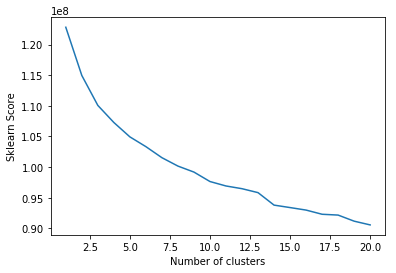

In [48]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.plot(clusters, kmeans_score)
plt.xlabel('Number of clusters')
plt.ylabel('Sklearn Score')
plt.show()

In [55]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = KMeans(12)
kmeans.fit(X_pca)
azdias_predictions = kmeans.predict(X_pca)

In [56]:
print(azdias_predictions[:10])

[ 0  2  6  5  2  1 10  4  2 11]


### Discussion 3.1: Apply Clustering to General Population

Unlike for the data in the unsupervised learning chapters, the kmeans clusters distance do no show a sharp decline after a certain increase in the number of clusters here. Instead the distance keeps in decreasing gradually as the number of clusters increase. As the number of cluster increase after 12, the slope of the sklearn score (average distance) decreases sharply till 15 clusters. This is the reason why I chose to go ahead with 12 KMeans cluster. 

It is also worth noting that the time taken to fit the data on clusters increase with the number of clusters. For 12 clusters, it took close to 4 minutes to converge on this CPU based workspace.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [211]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')

In [212]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customers_dropped_low = clean_data(customers)

(NAs before, NAs after) {'AGER_TYP': (0, 4631), 'ALTERSKATEGORIE_GROB': (0, 240), 'GEBURTSJAHR': (0, 93024), 'LP_LEBENSPHASE_FEIN': (3213, 51053), 'LP_LEBENSPHASE_GROB': (3213, 50941), 'LP_FAMILIE_FEIN': (3213, 50582), 'LP_FAMILIE_GROB': (3213, 50582), 'NATIONALITAET_KZ': (0, 48750), 'PRAEGENDE_JUGENDJAHRE': (0, 48487), 'TITEL_KZ': (46596, 189340), 'ALTER_HH': (46596, 68747), 'W_KEIT_KIND_HH': (53742, 56937), 'ANZ_HAUSHALTE_AKTIV': (49927, 52377), 'KBA05_BAUMAX': (55980, 109535), 'KBA05_GBZ': (55980, 55982), 'KKK': (54260, 60064), 'REGIOTYP': (54260, 60064), 'ARBEIT': (50476, 50499), 'RELAT_AB': (50476, 50499)}
(141911, 76)
{'ZABEOTYP_4', 'ZABEOTYP_6', 'ZABEOTYP_2', 'ZABEOTYP_1', 'ZABEOTYP_5', 'ZABEOTYP_3'}
(141911, 81)
{'FINANZTYP_6', 'FINANZTYP_3', 'FINANZTYP_2', 'FINANZTYP_4', 'FINANZTYP_1', 'FINANZTYP_5'}
(141911, 83)
{'NATIONALITAET_KZ_1.0', 'NATIONALITAET_KZ_3.0', 'NATIONALITAET_KZ_2.0'}
(141911, 87)
{'LP_STATUS_GROB_3.0', 'LP_STATUS_GROB_5.0', 'LP_STATUS_GROB_4.0', 'LP_STATUS_GR

In [213]:
# A column is missing in the customers data after one hot encoding
# Got the following error while transforming using imputer - ValueError: X has 195 features per sample, expected 196
missing_col = list(set(azdias_dropped_low.columns) - set(customers_dropped_low.columns))[0]
print(missing_col)
customers_dropped_low[missing_col] = 0
missing_col = list(set(azdias_dropped_low.columns) - set(customers_dropped_low.columns))
print(missing_col)

GEBAEUDETYP_5.0
[]


In [214]:
customers_dropped_low = imputer.transform(customers_dropped_low)
customers_dropped_low = scaler.transform(customers_dropped_low)
customers_dropped_low = pca.transform(customers_dropped_low)

In [215]:
customers_predictions = kmeans.predict(customers_dropped_low)
print(np.unique(customers_predictions, return_counts=True))
print(len(customers_predictions))

(array([4], dtype=int32), array([141911]))
141911


### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

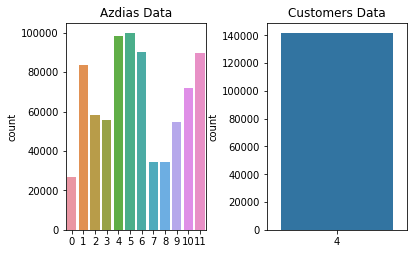

In [216]:
# Quite astonishingly, all the customers belong to 1 cluster, indexed 4, when clustered using the same KMeans object which was fit on the azdias data.
# Getting the idea from the instructions, here I am plotting the distribution of individuals in the clusters for both azdias and customer data.

# Defining a method as this would be used to plot the proportion data as well eventually.

def plot_clusters(ax1_data, ax2_data, *clusters):
    fig, (ax1, ax2) = plt.subplots(1,2) # Two columns for both groups 
    fig.tight_layout(pad=3.0)
    ax1.set_title('Azdias Data')
    ax2.set_title('Customers Data')
    if len(clusters) > 0:
        sns.barplot(ax1_data, clusters[0], ax=ax1)
        sns.barplot(ax2_data, clusters[1], ax=ax2)
    else:
        sns.countplot(ax1_data, ax=ax1)
        sns.countplot(ax2_data, ax=ax2)
    plt.show()

plot_clusters(azdias_predictions, customers_predictions)

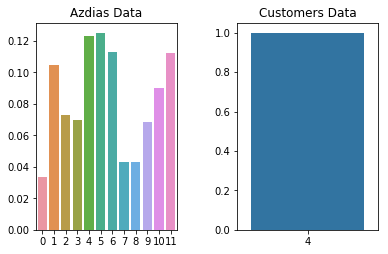

In [217]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

az_cluster, az_counts = np.unique(azdias_predictions, return_counts=True)
cu_cluster, cu_counts = np.unique(customers_predictions, return_counts=True)
az_counts = az_counts/azdias_dropped_low.shape[0]
cu_counts = cu_counts/customers_dropped_low.shape[0]
plot_clusters(az_cluster, cu_cluster, az_counts, cu_counts)

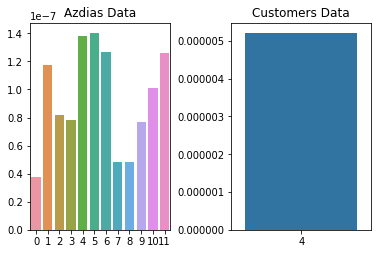

In [218]:
# As the distribution of columns were different in the high missing values and the low missing values dataset, it makes sense to see the distriution in the overall dataset as well.

az_counts_all = az_counts/azdias.shape[0]
cu_counts_all = cu_counts/customers.shape[0]
plot_clusters(az_cluster, cu_cluster, az_counts_all, cu_counts_all)

In [219]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
diff = [0] * len(az_cluster)
for i in range(len(az_cluster)):
    try:
        k = list(cu_cluster).index(i)
        diff[i] = cu_counts[k]
    except:
        diff[i] = 0
    finally:
        k = -1

diff = az_counts - diff
print("FOR LOW MISSING VALUES DATA:")
for i, v in enumerate(diff):
    if v > 0:
        print('For cluster {}, the difference in azdias data proportion and customer data proportion is {:.3f}%'.format(i, v*100))

print("\n\nFOR ALL DATA:")
diff_all = [0] * len(az_cluster)
for i in range(len(az_cluster)):
    try:
        k = list(cu_cluster).index(i)
        diff_all[i] = cu_counts_all[k]
    except:
        diff_all[i] = 0
    finally:
        k = -1

diff_all = az_counts_all - diff_all
for i, v in enumerate(diff_all):
    if v > 0:
        print('For cluster {}, the difference in azdias data proportion and customer data proportion is {}%'.format(i, v*100))

FOR LOW MISSING VALUES DATA:
For cluster 0, the difference in azdias data proportion and customer data proportion is 3.338%
For cluster 1, the difference in azdias data proportion and customer data proportion is 10.461%
For cluster 2, the difference in azdias data proportion and customer data proportion is 7.313%
For cluster 3, the difference in azdias data proportion and customer data proportion is 6.992%
For cluster 5, the difference in azdias data proportion and customer data proportion is 12.522%
For cluster 6, the difference in azdias data proportion and customer data proportion is 11.314%
For cluster 7, the difference in azdias data proportion and customer data proportion is 4.332%
For cluster 8, the difference in azdias data proportion and customer data proportion is 4.323%
For cluster 9, the difference in azdias data proportion and customer data proportion is 6.817%
For cluster 10, the difference in azdias data proportion and customer data proportion is 9.016%
For cluster 11, t

In [220]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
print("FOR LOW MISSING VALUES DATA:")
for i, v in enumerate(diff):
    if v < 0:
        print('For cluster {}, the difference in azdias data proportion and customer data proportion is {:.3f}%'.format(i, v*100))

print("\n\nFOR ALL DATA:")
for i, v in enumerate(diff_all):
    if v < 0:
        print('For cluster {}, the difference in azdias data proportion and customer data proportion is {}%'.format(i, v*100))

FOR LOW MISSING VALUES DATA:
For cluster 4, the difference in azdias data proportion and customer data proportion is -87.678%


FOR ALL DATA:
For cluster 4, the difference in azdias data proportion and customer data proportion is -0.0005079533383267425%


In [221]:
# Cluster 4 is the only cluster overrepresented in the customers data
features = pca.inverse_transform(kmeans.cluster_centers_[4])
idx = np.argsort(features)
sorted_features = np.array(azdias_dropped_low.columns[idx])
features_unscaled = scaler.inverse_transform(features)
features_unscaled.sort()
print('The top most features for this cluster are: {} having values {}'.format(sorted_features[-5:], features_unscaled[-5:]))
print('The bottom most features for this cluster are: {} having values'.format(sorted_features[:5]), features_unscaled[:5])

The top most features for this cluster are: ['FINANZ_MINIMALIST' 'MOVEMENT' 'GREEN_AVANTGARDE' 'LP_STATUS_FEIN_10.0'
 'LP_STATUS_GROB_5.0'] having values [    5.1640013      8.57153876    67.28113454   701.2380065   1993.03553333]
The bottom most features for this cluster are: ['HH_EINKOMMEN_SCORE' 'WEALTH' 'FINANZ_HAUSBAUER' 'LP_STATUS_GROB_1.0'
 'FINANZ_SPARER'] having values [-0.01338794 -0.00790186 -0.00270376 -0.00262956 -0.00181874]


In [222]:
# Cluster 5 is the cluster underrepresented in the customers data
features = pca.inverse_transform(kmeans.cluster_centers_[5])
idx = np.argsort(features)
sorted_features = np.array(azdias_dropped_low.columns[idx])
features_unscaled = scaler.inverse_transform(features)
features_unscaled.sort()
print('The top most features for this cluster are: {} having values {}'.format(sorted_features[-5:], features_unscaled[-5:]))
print('The bottom most features for this cluster are: {} having values'.format(sorted_features[:5]), features_unscaled[:5])

The top most features for this cluster are: ['WEALTH' 'RETOURTYP_BK_S' 'SEMIO_VERT' 'FINANZTYP_5' 'LP_STATUS_FEIN_1.0'] having values [    8.10165104    15.0301289     65.40997655   558.98271474  1992.61944594]
The bottom most features for this cluster are: ['ANREDE_KZ' 'FINANZ_ANLEGER' 'SEMIO_RAT' 'SEMIO_KAEM'
 'FINANZ_UNAUFFAELLIGER'] having values [-0.01210817 -0.00693978 -0.00693978 -0.00383256 -0.00352043]


### Discussion 3.3: Compare Customer Data to Demographics Data

As the distribution of data was different for low missing values dataset and high missing value dataset, it was logical to put both the datasets in purview for analysis against customer dataset. It turns out that all the customers were predicted to be in cluster 4 which looks a bit strange. However, double checking every step makes me wonder that it might be an expected behavior. Anyway, all the customers belong to cluster 4, so it is logical to see an overrepresentation in that cluster and underrepresentation in all the others. This is what I saw for both low missing value dataset and the overall azdias dataset.

Cluster 4 is overreprsented by 87.67% and Cluster 5 is underrepresented by 12.5% which is the maximum across all clusters. I analysed these two for the topmost factors resulting in these clusters. 

 - **Cluster 4 (Over representation)**: The top most features for this cluster are: 'FINANZ_MINIMALIST', 'MOVEMENT', 'GREEN_AVANTGARDE', 'LP_STATUS_FEIN_10.0', 'LP_STATUS_GROB_5.0' having values 5.1640013, 8.57153876, 67.28113454, 701.2380065, 1993.03553333 respectively. The bottom most features for this cluster are: 'HH_EINKOMMEN_SCORE', 'WEALTH', 'FINANZ_HAUSBAUER', 'LP_STATUS_GROB_1.0', 'FINANZ_SPARER' having values -0.01338794, -0.00790186, -0.00270376, -0.00262956, -0.00181874. 
 
    Both LP_STATUS_FEIN_10.0 and LP_STATUS_GROB_5.0 represent the top earners on fine and coarse scale. Membership in environmental sustainability as part of youth is denoted by GREEN_AVANTGARDE. MOVEMENT variable denotes if the movement was AVANTGARDE or MAINSTREAM. FINANZ_MINIMALIST represents low financial interest. The individuals belonging to this cluster have high income and spending capacity and should be targetted by the mail-order sales company. The variables impacting negatively are in line with the analysis as they are opposite to the positively impacting variables in nature.
    
    
 - **Cluster 5 (Under representation)**: The top most features for this cluster are: 'WEALTH', 'RETOURTYP_BK_S', 'SEMIO_VERT', 'FINANZTYP_5', 'LP_STATUS_FEIN_1.0' having values 8.10165104, 15.0301289, 65.40997655, 558.98271474, 1992.61944594. The bottom most features for this cluster are: 'ANREDE_KZ', 'FINANZ_ANLEGER', 'SEMIO_RAT', 'SEMIO_KAEM', 'FINANZ_UNAUFFAELLIGER' having values -0.01210817, -0.00693978, -0.00693978, -0.00383256, -0.00352043. One thing I'd like to immediately highlight is that this cluster converged on ANREDE_KZ which represents gender of the individual. This shouldn't be the case as gender shouldn't be a reason to assess whether to target someone for sales or not, however in this case the data pushed the algorithms to do so. The variables positive impacting variables represent the wealth of the individual, the shopping return type, dreamful personality, investor financial topology and low income. The negatively impacting variables include inconspicuous & investor financial type, rational and combative attitude. Even though it looks like this cluster is confused in terms of the deciding factors, the low income class, inconspicuous financial type and personality type makes these individuals tough to target. 

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.